In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
dataset_path = r'C:\Users\gabde\Downloads\Data2'
class_folders = {
    "Non Demented": "Non Demented",
    "Very mild Dementia": "Very mild Dementia"
}

image_paths = []
labels = []

for class_idx, (class_name, folder_name) in enumerate(class_folders.items()):
    class_path = os.path.join(dataset_path, folder_name)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        image_paths.append(img_path)
        labels.append(class_idx)

image_paths = np.array(image_paths)
labels = np.array(labels)

In [3]:
img = Image.open(r'C:\Users\gabde\Downloads\Data2\Non Demented\OAS1_0381_MR1_mpr-4_130.jpg')
print("Режим:", img.mode)

Режим: RGB


In [4]:
def preprocess_image(image_path):
    """Загрузка и предобработка одного изображения"""
    # Загрузка в оттенках серого
    img = cv2.imread(image_path)
    
    # CLAHE для улучшения контраста
    # clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    # img = clahe.apply(img)
    
    # Изменение размера
    img = cv2.resize(img, (224, 224))
    
    # Нормализация
    img = img.astype(np.float32) / 255.0
    
    # Добавление канала
    # img = np.expand_dims(img, axis=-1)
    
    return img

images = []
images.append(preprocess_image(r'C:\Users\gabde\Downloads\Data2\Non Demented\OAS1_0381_MR1_mpr-4_130.jpg'))
images = np.array(images)
images.shape

(1, 224, 224, 3)

In [5]:
images = []

for path in image_paths:
    images.append(preprocess_image(path)) 

images = np.array(images)
X_train, X_test, y_train, y_test = train_test_split(
    images, labels,
    test_size=0.2,
    random_state=42
)

In [6]:
del images

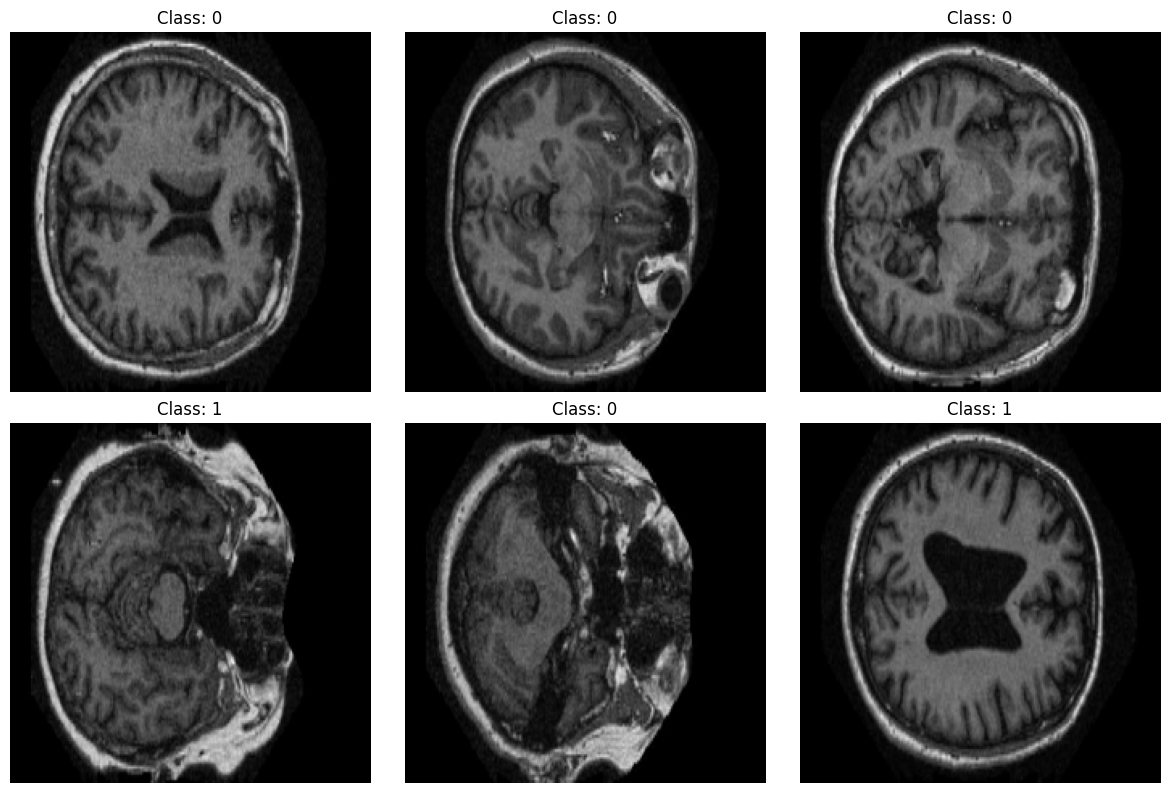

In [7]:
def show_batch(images, labels, n_images=6):
    plt.figure(figsize=(12, 8))
    
    # Обработка разных форматов ввода
    if isinstance(images, tuple) and len(images) == 2:
        images, labels = images
        
    # Преобразуем в список для унификации
    images = list(images)
    labels = list(labels)
    
    # Ограничиваем количество изображений
    n_images = min(n_images, len(images))
    
    for i in range(n_images):
        ax = plt.subplot(2, 3, i+1)
        
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Class: {labels[i]}")
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()

show_batch(X_train[:32], y_train[:32])

In [8]:
def feature_extractor(inputs):
	feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),include_top=False,weights='imagenet')(inputs)
	return feature_extractor


In [9]:
def classifier_layers(inputs):
	x = GlobalAveragePooling2D()(inputs)
	x = Flatten()(x)
	x = Dense(1024, activation="relu")(x)
	x = Dense(512, activation="relu")(x)
	x = Dense(1, activation="sigmoid", name="classification")(x) #sigmoid
	return x

In [10]:
def compile_model():
    inputs = Input(shape=(224, 224, 3))
    resnet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier_layers(resnet_feature_extractor)
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model 

model = compile_model()  
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification (Dense)               │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,211,201 (99.99 MB)

 Trainable params: 26,158,081 (99.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [11]:
os.makedirs('model_weights', exist_ok=True)

# Callback для сохранения весов после каждой эпохи
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights/weights_epoch_{epoch:02d}.weights.h5',  # Шаблон имени файла
    save_weights_only=True,  # Сохраняем только веса (не всю модель)
    save_freq='epoch',  # Сохранять после каждой эпохи
    verbose=1  # Выводить сообщение при сохранении
)

In [12]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=3,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint_callback]
)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\naccuracy on test data: {test_acc:.4f}')

Epoch 1/3
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8297 - loss: 0.3896
Epoch 1: saving model to model_weights/weights_epoch_01.weights.h5
563/563 ━━━━━━━━━━━━━━━━━━━━ 3284s 6s/step - accuracy: 0.8299 - loss: 0.3893 - val_accuracy: 0.5098 - val_loss: 20.3723
Epoch 2/3
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9810 - loss: 0.0523
Epoch 2: saving model to model_weights/weights_epoch_02.weights.h5
563/563 ━━━━━━━━━━━━━━━━━━━━ 3244s 6s/step - accuracy: 0.9810 - loss: 0.0523 - val_accuracy: 0.8994 - val_loss: 0.2080
Epoch 3/3
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9872 - loss: 0.0374
Epoch 3: saving model to model_weights/weights_epoch_03.weights.h5
563/563 ━━━━━━━━━━━━━━━━━━━━ 3248s 6s/step - accuracy: 0.9872 - loss: 0.0374 - val_accuracy: 0.7167 - val_loss: 2.1210
141/141 - 160s - 1s/step - accuracy: 0.7167 - loss: 2.1210

accuracy on test data: 0.7167


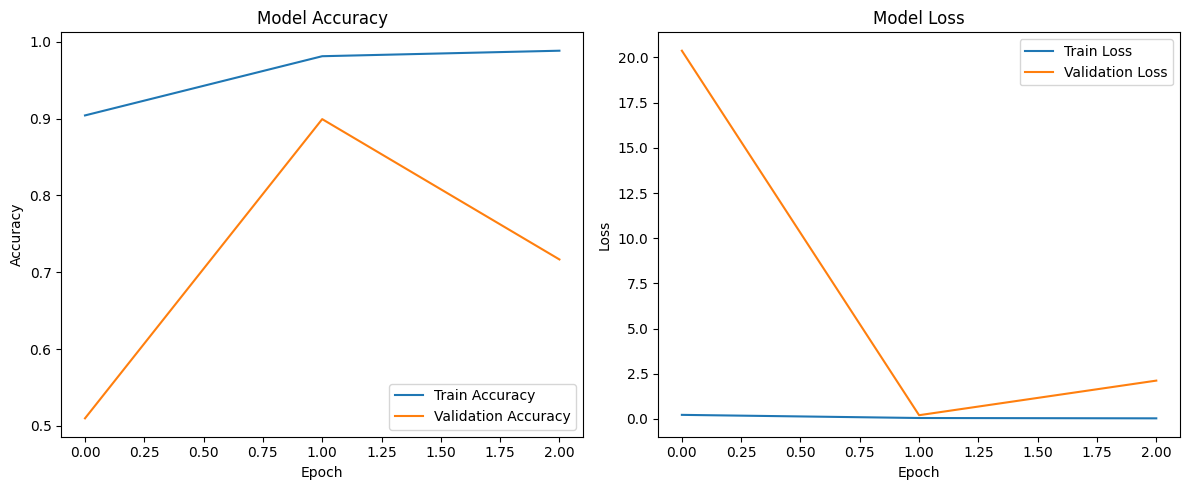

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# График потерь (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [19]:
def iterp(predictions):
    class_label = "Dementia" if predictions[0][0] > 0.5 else "Non Demented"
    confidence = predictions[0][0] if predictions[0][0] > 0.5 else 1 - predictions[0][0]
    print(f"Predicted class: {class_label}")
    print(f"Confidence: {confidence:.2%}")
    print(f"Raw probabilities: {predictions[0]}")

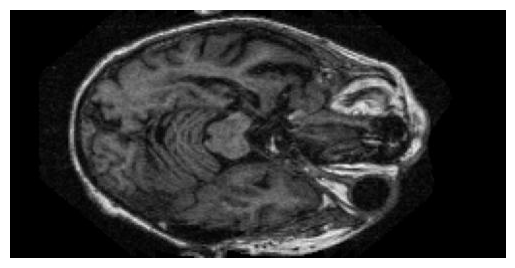

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted class: Dementia
Confidence: 100.00%
Raw probabilities: [0.9999699]


In [28]:
# dementia  
images = []
img_path = r'C:\Users\gabde\Downloads\Data2\Very mild Dementia\OAS1_0380_MR1_mpr-4_127.jpg'
images.append(preprocess_image(img_path))
plt.imshow(image.load_img(img_path))
plt.axis('off')
plt.show()
images = np.array(images)
iterp(model.predict(images))

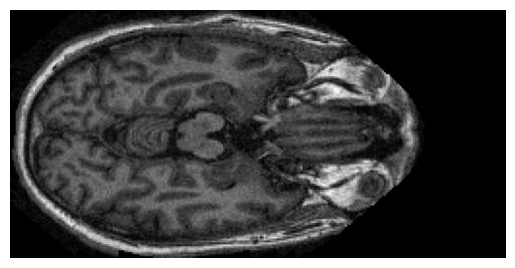

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted class: Non Demented
Confidence: 100.00%
Raw probabilities: [7.047806e-16]


In [30]:
# non dementia  
images = []
img_path = r'C:\Users\gabde\Downloads\Data2\Non Demented\OAS1_0381_MR1_mpr-4_134.jpg'
images.append(preprocess_image(img_path))
plt.imshow(image.load_img(img_path))
plt.axis('off')
plt.show()
images = np.array(images)
iterp(model.predict(images))